In [1]:
# Denoising Diffusion Probabilistic Models, CIFAR-10 dataset

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np

# we already built out the UNet in the previous notebook
# so we import it from the src folder
from src.unet import UNet
from src.ddpm import train_model, validate_model
from src.utils import show_torch_image

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
cifar10_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
train_dataset, val_dataset = random_split(cifar10_full, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Files already downloaded and verified
Train dataset size: 40000
Validation dataset size: 10000
Number of training batches: 313
Number of validation batches: 79


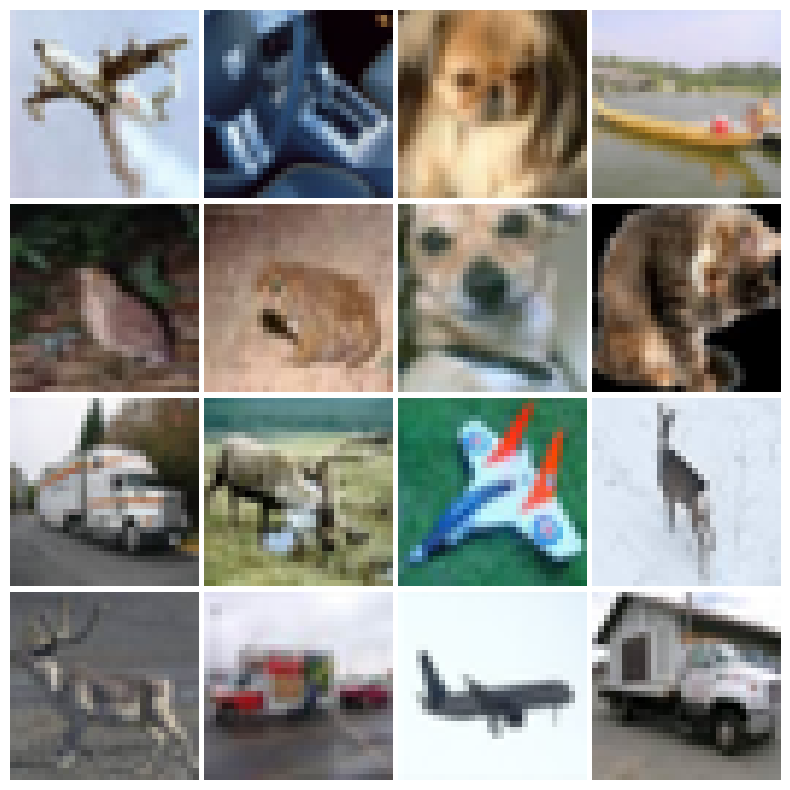

In [3]:
def show_image_grid(dataset, num_images=16, rows=4, cols=4):
    """
    Display a grid of images from a PyTorch dataset.
    
    Args:
        dataset: PyTorch dataset
        num_images: Total number of images to display (default: 16)
        rows: Number of rows in the grid (default: 4)
        cols: Number of columns in the grid (default: 4)
    """
    assert num_images <= len(dataset), "num_images should not exceed dataset size"
    assert rows * cols == num_images, "rows * cols should equal num_images"
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    
    for i in range(num_images):
        img, _ = dataset[i]
        row = i // cols
        col = i % cols
        
        img = img * 0.5 + 0.5  
        img = img.permute(1, 2, 0).numpy()
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    plt.show()

# Example usage:
show_image_grid(train_dataset)


In [4]:
model = UNet(
    down_filters=[64, 128, 256, 256], 
    in_channels=3, 
    num_layers=2, 
    has_attention=[False, True, False, False], 
    num_heads=8, 
    diffusion_steps=1000,
    num_groups=8, 
    activation=nn.ReLU, 
    dropout=0.1
)

In [5]:
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
data_loaders = {'train': train_loader, 'val': val_loader}
loss_fn = nn.MSELoss()
beta_schedule = torch.linspace(0.0001, 0.02, 1000)
epochs = 20

train_loss, valid_loss = train_model(
    model=model,
    loaders=data_loaders,
    epochs=epochs,
    optim=optim,
    scheduler=scheduler,
    loss_fn=loss_fn,
    beta_schedule=beta_schedule,
)

Epoch 0 of 20


pre res block in conv block: torch.Size([128, 3, 32, 32])
timestep_emb: torch.Size([128, 64, 1, 1])
h: torch.Size([128, 64, 32, 32])
post res block in conv block: torch.Size([128, 64, 32, 32])
pre res block in conv block: torch.Size([128, 64, 32, 32])
timestep_emb: torch.Size([128, 64, 1, 1])
h: torch.Size([128, 64, 32, 32])
post res block in conv block: torch.Size([128, 64, 32, 32])
post conv block 0: torch.Size([128, 64, 32, 32])
pre res block in conv block: torch.Size([128, 64, 16, 16])
timestep_emb: torch.Size([128, 128, 1, 1])
h: torch.Size([128, 128, 16, 16])
post res block in conv block: torch.Size([128, 128, 16, 16])
pre res block in conv block: torch.Size([128, 128, 16, 16])
timestep_emb: torch.Size([128, 128, 1, 1])
h: torch.Size([128, 128, 16, 16])
post res block in conv block: torch.Size([128, 128, 16, 16])
post conv block 1: torch.Size([128, 128, 16, 16])
pre res block in conv block: torch.Size([128, 128, 64])
timestep_emb: torch.Size([128, 256, 1, 1])
h: torch.Size([256, 

RuntimeError: output with shape [256, 128, 64] doesn't match the broadcast shape [128, 256, 128, 64]

In [6]:
model

UNet(
  (activation): ReLU()
  (timestep_embedding): TimestepEmbedding(
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (activation): ReLU()
  )
  (left_block): LeftBlock(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (convs): ModuleList(
          (0): ResBlock(
            (norm1): Sequential(
              (0): GroupNorm(1, 3, eps=1e-05, affine=True)
              (1): ReLU()
            )
            (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): GroupNorm(1, 64, eps=1e-05, affine=True)
            )
            (activation): ReLU()
            (idconv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
            (avgpool): Identity()
            (dropout): Dropout(p=0.1, inplace=False)
            (timestep_emb_pro